# Comparación de 3 cabriadas

En este ejemplo se comparan tres opciones de cabriadas del tipo viga en celosía, observando las tensiones máximas de tracción y compresión así como las deformaciones máximas y los pesos totales de cada cabriada. La luz a cubrir es de $35.32m$.

El objetivo es determinar la configuración más eficiente comparando las tensiones y deformaciones máximas además de los pesos totales.

En líneas generales los pasos son los siguientes:
1. Se define la carga superficial vertical de techo;
3. Se construyen automáticamente la geometría de las 3 cabriadas, a partir de parámetros, utilizando la librería 'struct_gen';
4. Se cargan datos de perfiles aisc y se asignan perfiles a los cordones longitudinales y a las diagonales;
3. Los cálculos de tensiones y pesos se realizan con la librería 'edeb'.

## Librerías

In [1]:
# Librerías de python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Indica la ubicación de la carpeta 'strucktura' para importar los módulos
# struct_gen y edeb
import sys
sys.path.append(r"C:\Users\fgrv\OneDrive\Documentos\PythonProjects\struktura")

# Se importan los módulos
import analisa.struct_gen as sg  # Generación automática de pórticos
import analisa.edeb as edb  # Para la realización de los cálculos

## 1. Carga superficial vertical

Se define una carga uniformemente distribuida en toda la superficie del techo.

Convenión de signos:
- Positivo: hacia arriba
- Negativo: hacia abajo

In [2]:
# Carga positiva hacia arriba
q = -1000  # N/m2

## 2. Generación automática de las cabriadas

Se utiliza el módulo *struct_gen* y el constructor *LatticeBeam* cuyos parámetros son, entre paréntesis los valores por defecto:

- a: Lado horizontal izquierdo de la cabriada (10)
- b: Lado horizontal derecho de la cabriada (10)
- nL: Número de divisiones en el lado izquierdo (2)
- nr: Número de divisiones en el lado derecho (3)
- dL: Altura de la cabriada en el lado izquierdo (1)
- dr: Altura de la cabriada en el lado derecho (1)
- hL: Altura del apoyo izquierdo (0)
- hm: Altura de la parte superior de la cabriada (cumbrera) (2)
- hr: Altura del apoyo derecho (0)
- long_mat: Número asignado al material utilizado en los cordones longitudinales (1)
- long_sec: Número asignado al tipo de sección para los cordones longitudinales (1)
- diag_mat: Número para el material de las diagonales (1)
- diag_sec: Número para el tipo de perfil de las diagonales (1)
- sup_vert_load: Carga vertical de superficie (1)
- trus_sep: Separación entre cabriadas (distancia entre cabriadas) (5)
- nod_dist_purlins: Distancia entre correas en términos de cantidad de nudos (1)

Empezamos definiendo la *luz* a cubrir

In [3]:
# Luz total a cubrir con las cabriadas
luz = 35.32  # m

Le pasamos al *constructor* los parámetros de las cabriadas

In [4]:
# Instanciación de la clase LatticeBeam
cab1 = sg.LatticeBeam(a=luz/2, b=luz/2, nL=17, nr=17, dL=1, dr=1, 
                     sur_vert_load=q, nod_dist_purlins=1, hm=2.12,
                     title='Cabriada 1')

cab2 = sg.LatticeBeam(a=luz/2, b=luz/2, nL=17, nr=17, dL=1, dr=1, 
                     sur_vert_load=q, nod_dist_purlins=1, hm=2.65,
                     title='Cabriada 2')

cab3 = sg.LatticeBeam(a=17.66, b=17.66, nL=34, nr=34, dL=1, dr=1, 
                     sur_vert_load=q, nod_dist_purlins=2, hm=2.12,
                     title='Cabriada 3')

A continuación se realizan los cálculos necesarios para generar la geometría y las cargas nodales de cada cabriada.

In [5]:
cab1.builder()
cab2.builder()
cab3.builder()

Visualizamos las geometrías generadas

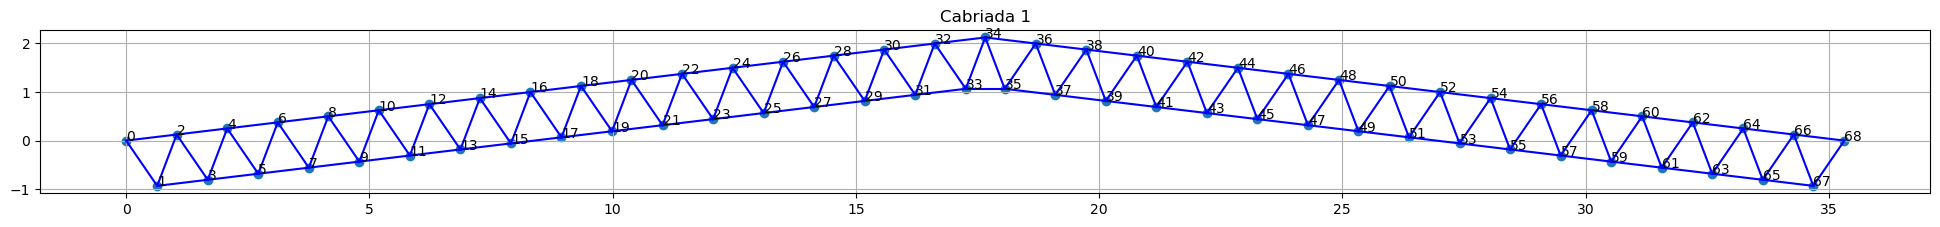

In [6]:
cab1.plot(node_numbering=True)

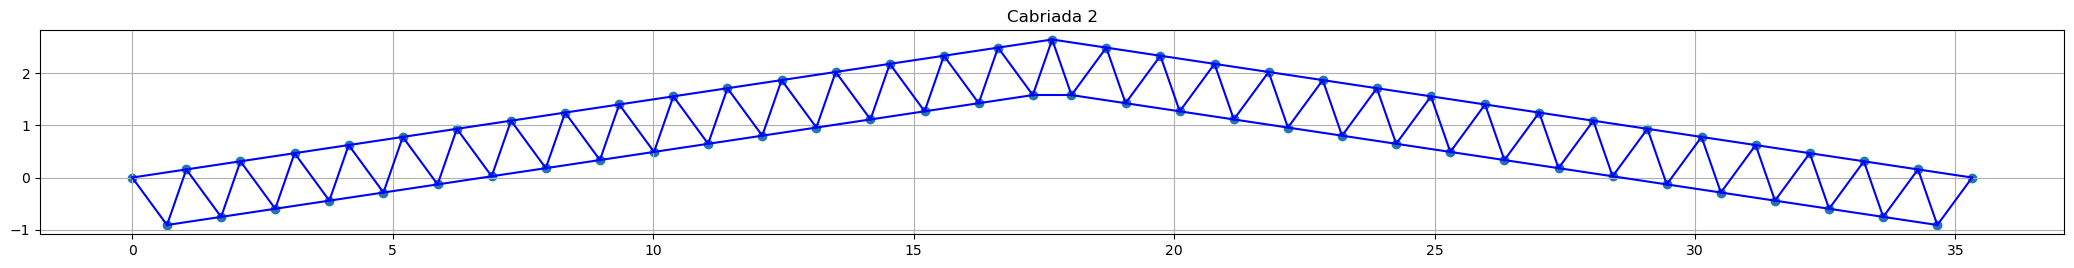

In [7]:
cab2.plot()

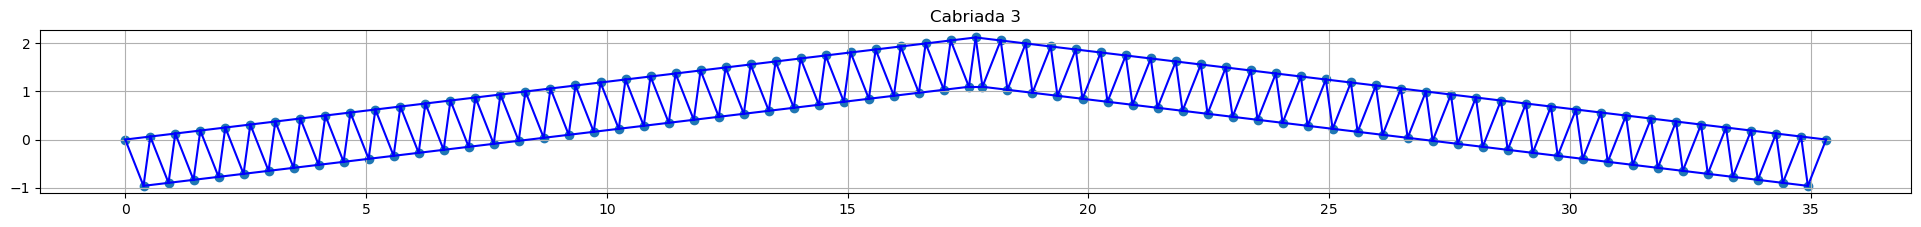

In [8]:
cab3.plot()

Luego de verificar que los gráficos reproducen correctamente las estructuras deseadas, pasamos a calcularlas.

## 3. Datos de perfiles

Se carga la base de datos de perfiles de la AISC

In [9]:
# Ubicación de la base de datos
f1 = "../analisa/database/aisc-shapes-database-v15.0.xlsx"

# Lectura de la base de datos con pandas
aisc = pd.read_excel(io=f1, sheet_name=1)

## 4. Cálculos estructurales

### 4.1 Obtención de las cargas nodales

In [10]:
# A partir de lo realizado con struct_gen
cargas1 = cab1.vloads  # Cargas nodales de la cabriada 1
cargas2 = cab2.vloads  # Cargas nodales de la cabriada 2
cargas3 = cab3.vloads  # Cargas nodales de la cabriada 3

### 4.2 Asignación de restricciones en los apoyos

In [11]:
# Restricción x e y en el primero y último apoyos (de segundo género)
rest1 = {0:(1, 1), cab1.nknots()-1:(1,1)}
rest2 = {0:(1, 1), cab2.nknots()-1:(1,1)}
rest3 = {0:(1, 1), cab3.nknots()-1:(1,1)}

### 4.3 Datos de materiales y secciones trasnversales

En este caso (por ser reticulado) el único parámetro definitorio del material es el módulo de elasticidad.

Utilizamos $E = 200 \, GPa$, que es el valor por defecto en la clase *Material* de *edeb*.

Para el cálculo del peso de la estructura se utilizará la densidad del acero $7850 \, kg/m^3$, que también es el valor por defecto de la clase *Material*.

**Nota**: Los pesos propios no son considerados en los cálculos ya que se trata de barras de 2 fuerzas.

In [12]:
# Material
mat = edb.Material()

Definición de las secciones transversales utilizando la base de datos AISC

In [13]:
# Perfil para los cordones longitudinales
longs = edb.perfil_aisc("2L2-1/2X2-1/2X3/16", aisc)  # Longs. sup e inf.

# Perfil para las diagonales
diags = edb.perfil_aisc("2L2X2X3/16", aisc)

# Lista de secciones utilizadas
secciones = [longs, diags]

Pasamos todos los parámetros al *constructor de reticulados* para la posterior realización de los cálculos.

In [16]:
# Reticulado 1
ret1 = edb.Reticulado(datos_nudos=cab1.node_coords,
                      datos_barras=cab1.conectivity,
                      materiales=mat, secciones=secciones,
                      restricciones=rest1, cargas_nodales=cargas1)

# Reticulado 2
ret2 = edb.Reticulado(datos_nudos=cab2.node_coords,
                      datos_barras=cab2.conectivity,
                      materiales=mat, secciones=secciones,
                      restricciones=rest2, cargas_nodales=cargas2)

# Reticulado 3
ret3 = edb.Reticulado(datos_nudos=cab3.node_coords,
                      datos_barras=cab3.conectivity,
                      materiales=mat, secciones=secciones,
                      restricciones=rest3, cargas_nodales=cargas3)

Se realizan de los cálculos:

In [17]:
ret1.procesamiento()  # Ejecución de cálculos en el reticulado 1
ret2.procesamiento()  # Cálculos para el reticulado 2
ret3.procesamiento()  # Cálculos para la cabriada 3

## 5. Resultados

### 5.1 Gráficos

Se grafica nuevamente cada estructura, esta vez para observar los resultados.

El método *dibujar_deform()* dibuja y puede colorear la estructura en su posición deformada.
- Barras traccionadas: en azul
- Barras comprimidas: en rojo

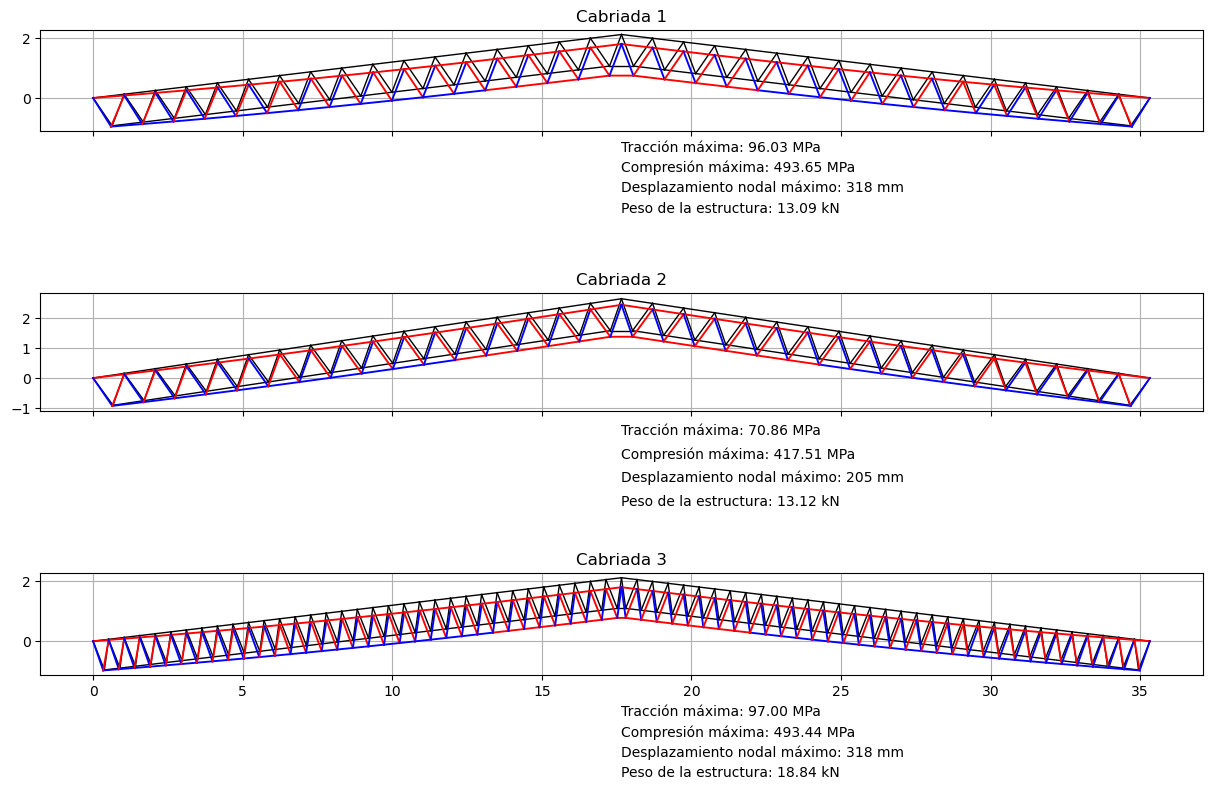

In [18]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 10), sharex=True)

cabs = [ret1, ret2, ret3]  # Lista de estructuras
for i, cab in enumerate(cabs):
    # Valores numéricos para comparación
    Ts = cab.tensiones()  # Obtención de las tensiones en todas las barras
    Tmax = np.max(Ts)  # Tracción máxima
    Cmax = -np.min(Ts)  # Compresión máxima
    delta_max = np.max(np.abs(cab.desplaz_gdl())) # Desplazamiento nodal máximo
    pp = cab.peso_propio() # Peso total de la estructura
    
    # Parte gráfica
    cab.dibujar_barras(ax=axs[i])  # Dibuja en su posición original
    cab.dibujar_deform(ax=axs[i], colorear=True, espesor_area=20) # Deformada
    posx = .5  # Posición relativa en x, de los textos
    if i < len(cabs) - 1:
        posy = [-.2, -.4, -.6, -.8]  # Posiciones relativas en y de los textos
    else: posy = [-.4, -.6, -.8, -1]
    axs[i].set_title(f'Cabriada {i + 1}')
    axs[i].annotate(f'Tracción máxima: {Tmax*1e-6:.2f} MPa',
                    xy=(posx, posy[0]), xycoords='axes fraction')
    axs[i].annotate(f'Compresión máxima: {Cmax*1e-6:.2f} MPa',
                    xy=(posx, posy[1]), xycoords='axes fraction')
    axs[i].annotate(f'Desplazamiento nodal máximo: {delta_max*1e3:.0f} mm',
                    xy=(posx, posy[2]), xycoords='axes fraction')
    axs[i].annotate(f'Peso de la estructura: {pp*1e-3:.2f} kN',
                    xy=(posx, posy[3]), xycoords='axes fraction')
